In [ ]:
"""CVaR is an improvement over VaR and is considered superior by practitioners. 
It takes into consideration the actual shape of the distribution and 
quantifies the tail risk. 
CVaR is also known as the expected shortfall since it 
measures the expectation of all the different possible losses greater than VaR.

Non-professional traders and investors should consider using 
CVaR over VaR for their own risk management. 
Unfortunately, most don’t.
"""

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from openbb_terminal.sdk import openbb

In [6]:
oex = ['MMM','T','ABBV','ABT','ACN','ALL','GOOGL','GOOG','MO','AMZN','AXP','AIG','AMGN','AAPL','BAC',
       'BRK-B','BIIB','BLK','BA','BMY','CVS','COF','CAT','CVX','CSCO','C','KO','CL','CMCSA',
       'COP','DHR','DUK','DD','EMC','EMR','EXC','XOM','META','FDX','F','GD','GE','GM','GILD',
       'GS','HAL','HD','HON','INTC','IBM','JPM','JNJ','KMI','LLY','LMT','LOW','MA','MCD','MDT','MRK',
       'MET','MSFT','MS','NKE','NEE','OXY','ORCL','PYPL','PEP','PFE','PM','PG','QCOM',
       'SLB','SPG','SO','SBUX','TGT','TXN','BK','USB','UNP','UPS','UNH','VZ','V','WMT',
       'WBA','DIS','WFC']

num_stocks = len(oex)

data = openbb.economy.index(oex, start_date = "2014-01-01", end_date = "2016-04-04")

The chosen index EMC, returns no data. Please check if there is any data available.

In [4]:
returns = data.pct_change()
returns = returns - returns.mean(skipna = True) # De-Mean the Returns
                                                # (De-meaning usually means 
                                                # subtracting the mean from all the values.)

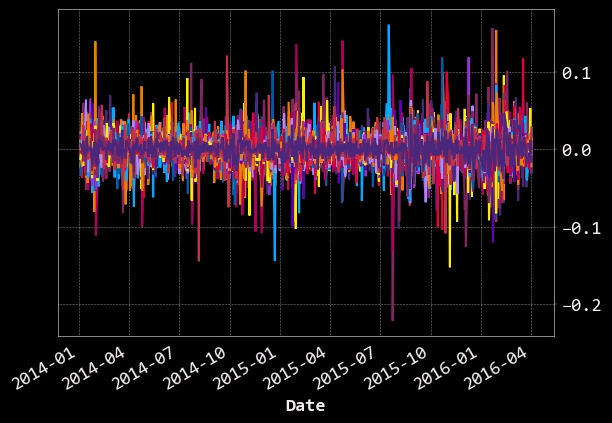

In [7]:
returns.plot(legend = None);

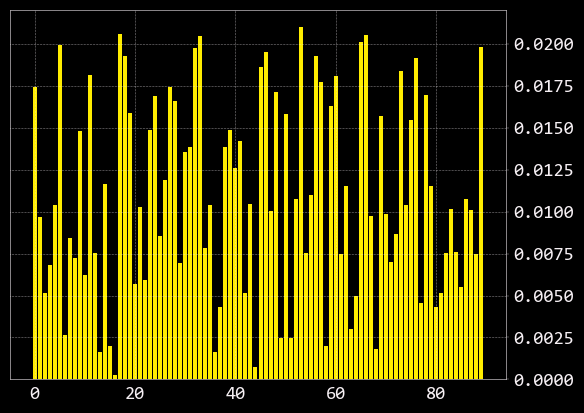

In [8]:
"""Create a mock portfolio by generating random weights and multiplying them 
by the returns. You can use your actual weights to represent your own portfolio.
"""

def scale(x):
    return x / np.sum(np.abs(x))

weights = scale(np.random.random(num_stocks))
plt.bar(np.arange(num_stocks), weights);

In [ ]:
#Build a function to compute VaR so we can compare it to CVaR.

In [9]:
def value_at_risk(
        value_invested,
        returns, weights,
        alpha = 0.95,
        lookback_days = 500
):
    returns = returns.fillna(0.0)
    portfolio_returns = returns.iloc[-lookback_days:].dot(weights)

    return np.percentile(portfolio_returns, 100 * (1-alpha)) * value_invested

In [ ]:
"""First, replace any NaNs with 0.0s in the DataFrame of returns. 
Then take the last few days of returns and multiply them by the 
portfolio weights to create portfolio returns. 
Finally, compute VaR by taking the 5th percentile of returns and
multiplying it by the value invested. 
This gets the amount you can expect to lose in one day with 95% confidence.

This is the main difference between VaR and CVaR. 
VaR represents a worst-case loss associated with a probability and a time horizon. 
CVaR is the expected loss if that worst-case threshold is crossed. 
In other words, CVaR quantifies the expected losses that occur beyond the VaR cutoff. 
VaR only measures the cutoff.
"""

In [10]:
value_invested = 1000000

value_at_risk(value_invested, returns, weights, alpha = 0.95, lookback_days = 520)

-15993.376162677288

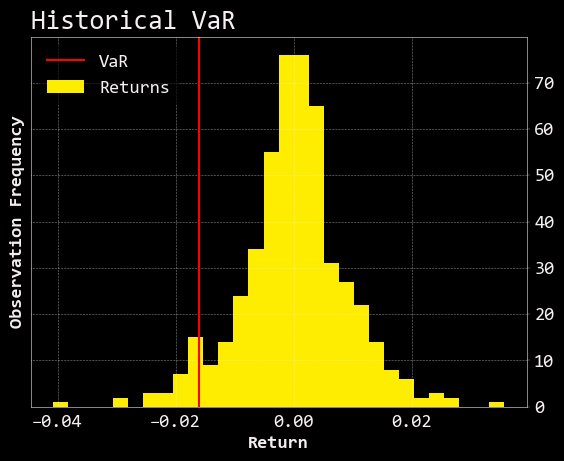

In [11]:
lookback_days = 500
alpha = 0.95

# Multiply asset returns by weights to get one weighted portfolio return
portfolio_returns = returns.fillna(0.0).iloc[-lookback_days:].dot(weights)

portfolio_VaR = value_at_risk(value_invested, returns, weights, alpha = 0.95)
# Need to express it as a returnr rather than absolute loss.
portfolio_VaR_return = portfolio_VaR / value_invested

plt.hist(portfolio_returns, bins = 30)
plt.axvline(portfolio_VaR_return, color = 'red', linestyle = 'solid');
plt.legend(['VaR','Returns'])
plt.title('Historical VaR');
plt.xlabel('Return');
plt.ylabel('Observation Frequency');

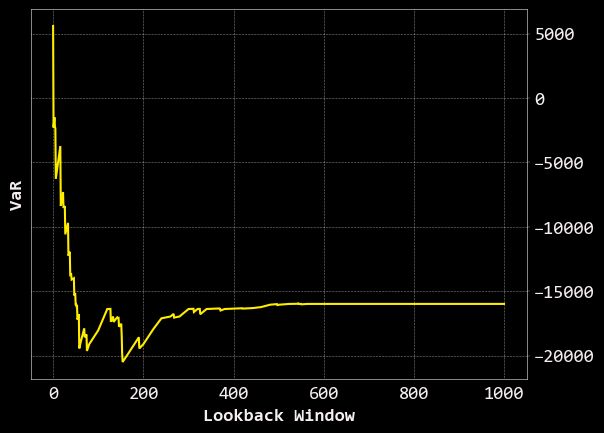

In [12]:
N = 1000
VaRs = np.zeros((N,1))
for i in range(N):
    VaRs[i] = value_at_risk(value_invested, returns, weights, lookback_days = i + 1)

plt.plot(VaRs)
plt.xlabel('Lookback Window')
plt.ylabel('VaR');

In [13]:
def cvar(
        value_invested,
        returns,
        weights,
        alpha = 0.95,
        lookback_days = 500
):
    var = value_at_risk(value_invested, returns, weights, alpha, lookback_days = lookback_days)

    returns = returns.fillna(0.0)
    portfolio_returns = returns.iloc[-lookback_days:].dot(weights)
    var_pct_loss = var/ value_invested

    return np.nanmean(portfolio_returns[portfolio_returns < var_pct_loss]) * value_invested

In [ ]:
"""Compute VaR to get the cutoff point on the distribution that equals the 5th percentile. 
Then compute the portfolio returns and convert VaR back to a 
percentage instead of a dollar amount. 
To compute CVaR, take the average of all 
returns less than VaR and multiply by the investedvalue.
Taking the average of all returns less than VaR is the same 
as taking the area of the distribution left of that cutoff point.
"""

In [15]:
cvar(value_invested, returns, weights, lookback_days  = 500)

-20937.09625861131

In [17]:
value_at_risk(value_invested, returns, weights, lookback_days = 500)

-16059.393145081174

Text(0, 0.5, 'Observation Frequency')

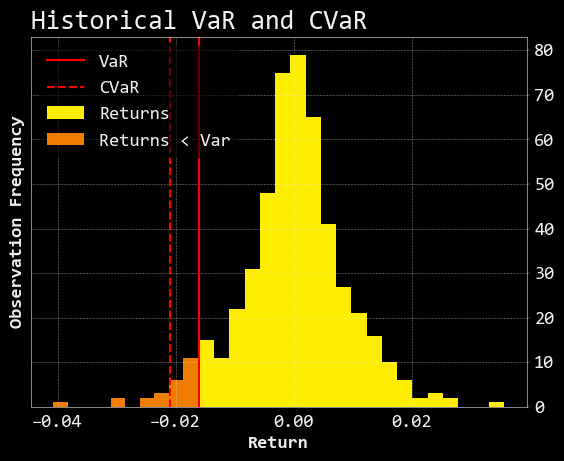

In [14]:
lookback_days = 500

portfolio_returns = returns.fillna(0.0).iloc[-lookback_days:].dot(weights)

portfolio_VaR = value_at_risk(value_invested, returns, weights)
portfolio_VaR_return = portfolio_VaR / value_invested

portfolio_CVaR = cvar(value_invested, returns, weights)
portfolio_CVaR_return = portfolio_CVaR / value_invested

plt.hist(portfolio_returns[portfolio_returns > portfolio_VaR_return], bins = 20)
plt.hist(portfolio_returns[portfolio_returns < portfolio_VaR_return], bins = 10)
plt.axvline(portfolio_VaR_return, color = 'red', linestyle = 'solid')
plt.axvline(portfolio_CVaR_return, color = 'red', linestyle = 'dashed')
plt.legend(['VaR', 'CVaR', 'Returns', 'Returns < Var'])
plt.title('Historical VaR and CVaR')
plt.xlabel('Return')
plt.ylabel('Observation Frequency')

In [18]:
"""The dashed line is CVaR and the solid line is VaR. 
VaR pinpoints the negative return at the 5th percentile. 
CVaR averages all the losses left of VaR (the orange bars), 
including the large negative return. Returns are not normally distributed. 
CVaR captures it.
"""

'The dashed line is CVaR and the solid line is VaR. \nVaR pinpoints the negative return at the 5th percentile. \nCVaR averages all the losses left of VaR (the orange bars), \nincluding the large negative return. Returns are not normally distributed. \nCVaR captures it.\n'